In [1]:
from LIMxCMBL.init import *
from scipy.integrate import simpson, trapezoid
import pickle
from tqdm import tqdm, trange

from LIMxCMBL.experiments import *
import matplotlib.pyplot as plt 

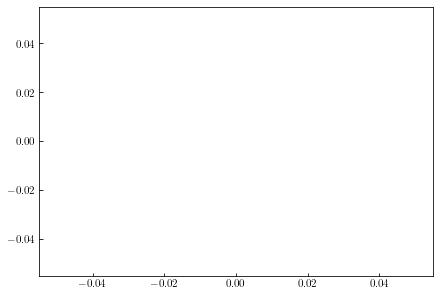

In [3]:
plt.plot()
plt.rcParams.update({
    "text.usetex": True,
    "font.size": "11",
    "font.family" : "serif",
    'figure.constrained_layout.use':True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'hatch.linewidth':0.1
})


e_colors = {
    'CHIME': '#8932B8',
    'HETDEX': '#3C44AA',
    'COMAP': '#5E7C16',
    'SPHEREx': '#F9801D',
    'CCAT-prime':'#B02E26'
}

e_order = ['CHIME',
          'HETDEX',
          'COMAP',
           'SPHEREx',
           'CCAT-prime']

kpar_funds = []
for experiment in e_order:
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)
    kpar_funds += [[kpar_fundamental, experiment]]
    
kpar_funds = list(reversed(sorted(kpar_funds)))

In [4]:
import matplotlib.patheffects as pe

In [6]:
xmin = 1.25e-3


In [31]:
sval = '0.95'


In [61]:
plt_left = plt.rcParams['figure.subplot.left']
plt_right = plt.rcParams['figure.subplot.right']
plt_cntr = (plt_left + plt_right) / 2


/tmp/ipykernel_32027/1811858305.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad = 0.0)


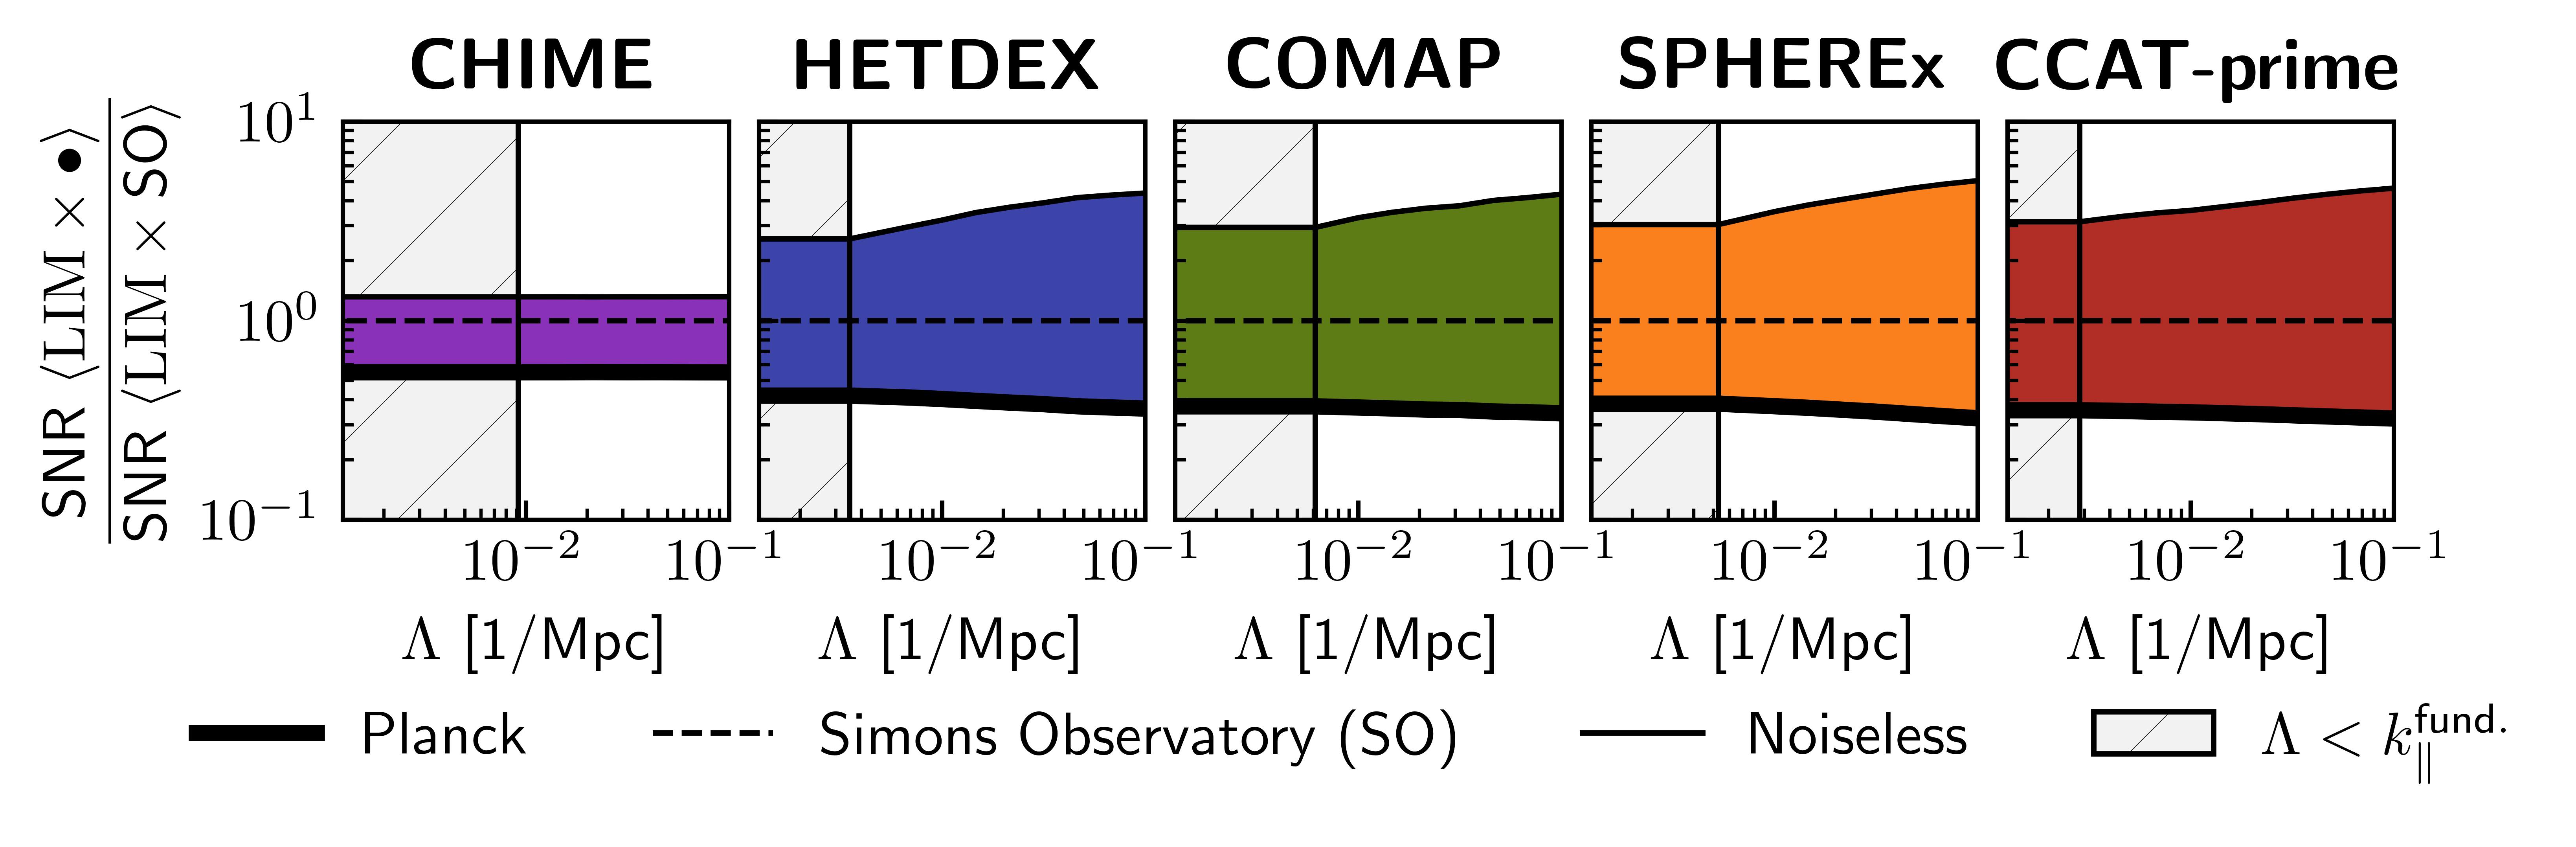

In [118]:
fig, meta_axs = plt.subplots(nrows=1, ncols=5, 
                             figsize = (5.5, 1.25), facecolor = 'w', dpi = 1000,
                             sharey=True,
                            )
plt.tight_layout(pad = 0.0)

for e_idx, experiment in enumerate(e_order):
    ax = meta_axs[e_idx]
    #metadata
    zmin = experiments[experiment]['zmin']
    zmax = experiments[experiment]['zmax']
    line_str = experiments[experiment]['line_str']
    
    Omega_field  =  np.array(experiments[experiment]['Omega_field'].to(u.rad**2)) #rad^2
    chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
    chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
    
    kpar_fundamental = 2*np.pi/(chimax - chimin)

    ell_fundamental = np.sqrt((2*np.pi)**2 / Omega_field)
    ell_fundamental = max(np.array(ell_fundamental), 10)

    ell_max_survey = np.sqrt((np.pi)**2 / experiments[experiment]['Omega_pix'].to(u.rad**2).value)
    ell_max_survey = np.array(ell_max_survey)
    
#     print(experiment, ell_fundamental, ell_max_survey)
    c = e_colors[experiment]

    ax.axvspan(0, kpar_fundamental, facecolor=sval, 
               alpha=1, hatch='/',rasterized=True,
               linewidth=0, edgecolor="k")
    ax.axvline(kpar_fundamental, linewidth=1,color='k')


    
    def get_SNR(N0_fname = 'so'):
        inp_fname = '/scratch/users/delon/LIMxCMBL/SNR_011.007_N0_'+N0_fname+'_'
        with open(inp_fname+experiment+'_full.pkl', 'rb') as f:
            SNR2_per_mode_full = pickle.load(f)

        _Lambdas = np.array(sorted(list(SNR2_per_mode_full.keys())))

        #computing snr
        SNR2_per_Omega_full = np.zeros(len(_Lambdas))
        _idxs = np.where((ells >= ell_fundamental) & (ells <= ell_max_survey))

        for Lambda_idx,Lambda in enumerate(_Lambdas):
            SNR2_per_Omega_full[Lambda_idx] = trapezoid(x = np.log(ells)[_idxs], 
                                                        y = SNR2_per_mode_full[Lambda][_idxs] 
                                                        * ells[_idxs] ** 2 
                                                        / 2 / np.pi)
        SNR = np.sqrt(SNR2_per_Omega_full * Omega_field)
        return _Lambdas, SNR
        
    _Lambdas, SNR_SO = get_SNR(N0_fname = 'so')
    _Lambdas, SNR_Planck = get_SNR(N0_fname = 'planck')
    _Lambdas, SNR_Zero = get_SNR(N0_fname = 'zero')

    
    ls_s = ['-', '--', '-']
    lw_s = [3,1,1]
    
    for i, _y in enumerate([SNR_Planck/SNR_SO, SNR_SO/SNR_SO, SNR_Zero/SNR_SO]):
        
        
        _x = np.hstack(([0,kpar_fundamental], _Lambdas[1:]))
        _y = np.hstack(([_y[0]], _y))
        ax.plot(_x,
                 _y,
                 c='k', ls=ls_s[i], lw=lw_s[i],
                label=r'\textsf{%s}'%experiment)

    _x = np.hstack(([0,kpar_fundamental], _Lambdas[1:]))
    _y0 = np.hstack(([(SNR_Planck/SNR_SO)[0]], SNR_Planck/SNR_SO))
    _y1 = np.hstack(([(SNR_Zero/SNR_SO)[0]], SNR_Zero/SNR_SO))
    ax.fill_between(_x, _y0, _y1,
             color=e_colors[experiment], lw=0,)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xmin, 1e-1)
    ax.set_title(r'\textsf{\textbf{%s}}'%(experiment))
    ax.set_ylim(1e-1, 1e1)
    
    ax.set_xlabel(r'$\Lambda$ \sf[1/Mpc]')


from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_elements = [
    Line2D([0], [0], color='k', lw=3, label=r'\textsf{{Planck}}'),
    Line2D([0], [0], color='k', lw=1, ls='--', label=r'\textsf{{Simons Observatory (SO)}}'),
    Line2D([0], [0], color='k', lw=1, ls='-', label=r'\textsf{Noiseless}'),
    Patch(facecolor="0.95", hatch='/', edgecolor="k", lw=1, label=r'$\Lambda < k_\parallel^{\sf fund.}$')
]

fig.legend(handles=legend_elements, 
           loc='lower center',
           bbox_to_anchor=(plt_cntr, -0.5),
           frameon=False,
           ncol=4)

meta_axs[0].set_ylabel(r'$$\frac{{\sf SNR}\ {\langle {\rm LIM}\times\bullet\rangle}}{{\sf SNR}\ {\langle {\rm LIM}\times\textsf{{SO}}\rangle}}$$')


plt.savefig('figures/011.007.compare_N0.pdf', bbox_inches='tight')

[]

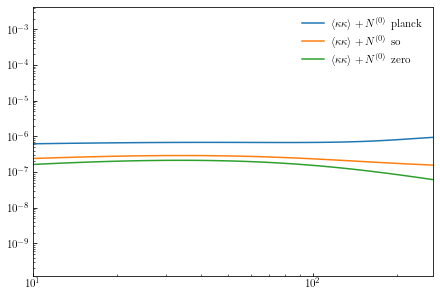

In [51]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) # dimensionless
# plt.plot(ells, ClKK, c='k', label=r'$\langle \kappa\kappa\rangle$')


from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)

for nm in ['planck', 'so', 'zero']:

    with open('data/N0_%s.npy'%(nm), 'rb') as f:
        N0 = np.load(f)
    f_N0 = interp1d(x = N0_ells, y = N0)
    plt.plot(ells, ClKK+f_N0(ells), label=r'$\langle \kappa\kappa\rangle+N^{(0)}$ '+nm)


plt.xlim(10, 270)
plt.legend(frameon=False)
plt.loglog()